# Questions
come fare in caso di traiettorie di joint sporche
come ha gestito markers mancanti
come ha mappato 40 -> 20
i qtm di wholodance, montpellier 08-07, 13-07
visualizzazione da millimetri a cosa (non sono centimetri perchè non ci sono 0.5 centimetri tra le gambe)

TODO CASO 9 USARE C7 COME CSHOULDER PER EVITARE EFFETTO TAVOLA
TODO casi montpellier la spine è piegata indietro perchè sembrano mancare punti della schiena

# Reading data from 20 Markers cleaned

In [1]:
import pandas as pd
import os
import numpy as np

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
annotations_file = ANNOTATIONS_PATH+'/annotationsVExamples.txt' #'/annotationsVSingle.txt'
with open(annotations_file,'r') as file:
    annotations = file.read().splitlines()[1:]

sampleAnno = 0

if '(A)' in annotations[sampleAnno] or '(B)' in annotations[sampleAnno]:
    folder, trial, fragId, _, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:7]
else:
    folder, trial, fragId, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:6]

file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
posTable = pd.read_csv(file)
# Assuming 'posTable' is your DataFrame, replace it with your actual DataFrame name
zero_indices = np.where(posTable == 0)

# 'zero_indices' is a tuple containing two arrays: one for row indices and one for column indices
row_indices, col_indices = zero_indices

# Print or use these indices as needed
print("Row Indices with Zeros:", row_indices)
print("Column Indices with Zeros:", posTable.columns[col_indices])
posTable.head()

Row Indices with Zeros: [26]
Column Indices with Zeros: Index(['right_hand_X'], dtype='object')


,left_foot_X,left_foot_Y,left_foot_Z,right_foot_X,right_foot_Y,right_foot_Z,left_ank_X,left_ank_Y,left_ank_Z,right_ank_X,...,left_shoulder_Z,shoulder_center_X,shoulder_center_Y,shoulder_center_Z,right_shoulder_X,right_shoulder_Y,right_shoulder_Z,head_X,head_Y,head_Z
0,0.358096,0.343706,0.127110,0.225119,0.343551,0.119641,0.359373,0.357824,0.162199,0.224058,...,0.133439,0.293992,0.918093,0.149125,0.237524,0.924857,0.133909,0.290775,1.000000,0.059749
1,0.358095,0.343704,0.127129,0.225110,0.343552,0.119646,0.359380,0.357813,0.162216,0.224038,...,0.133770,0.293981,0.917888,0.149378,0.237147,0.924366,0.134042,0.290865,0.999979,0.059888
2,0.358088,0.343711,0.127147,0.225091,0.343518,0.119671,0.359386,0.357794,0.162236,0.224020,...,0.134057,0.293952,0.917707,0.149594,0.236728,0.923785,0.134162,0.290950,0.999951,0.060036
3,0.358112,0.343700,0.127156,0.225088,0.343511,0.119679,0.359386,0.357814,0.162255,0.224004,...,0.134254,0.293935,0.917550,0.149749,0.236337,0.923294,0.134220,0.291023,0.999927,0.060205
4,0.358109,0.343702,0.127168,0.225088,0.343506,0.119682,0.359403,0.357794,0.162283,0.223997,...,0.134416,0.293927,0.917409,0.149867,0.235844,0.922699,0.134273,0.291093,0.999910,0.060380


In [29]:
posTableY = posTable.iloc[:,::3]+0.2
posTableZ = posTable.iloc[:,1::3]-np.min(posTable.iloc[:,1::3],axis=None)
posTableX = posTable.iloc[:,2::3]+0.1

posTableX = posTableX.rename(columns=dict(zip(list(posTableX),[name.replace('Z','X').replace('Y','X') for name in list(posTableX)])))
posTableY = posTableY.rename(columns=dict(zip(list(posTableY),[name.replace('Z','Y').replace('X','Y') for name in list(posTableY)])))
posTableZ = posTableZ.rename(columns=dict(zip(list(posTableZ),[name.replace('X','Z').replace('Y','Z') for name in list(posTableZ)])))

In [31]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))
adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True


plt.close("all")
fig = plt.figure()
ax:plt.Axes = fig.add_subplot(111, projection='3d')


minMax = np.zeros((2,3))
minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan']

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = posTableX.iloc[val]
    filteredY = posTableY.iloc[val]
    filteredZ = posTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,s=70)

    # Add edges based on the weight matrix
    for i in range(20):
        for j in range(i + 1, 20):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='gray', linestyle='-', linewidth=1.5)

    plt.rcParams['grid.color'] = 'white'
    ax.tick_params(axis='both', colors='w')
    ax.set_xlim([0,1])#minMax[0,0],minMax[1,0]])
    ax.set_ylim([0,1])#minMax[0,1],minMax[1,1]])
    ax.set_zlim([0,1])#minMax[0,2],minMax[1,2]])
    
    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)
    #ax.set_zlabel('Z', fontsize=12)
    #ax.set_title("Movement "+str(picked))
    #ax.grid(axis=['x','y'])
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # Remove box faces except the ground
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = True
    ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor((0,0,0))
    # Hide axis spines and ticks
    ax.w_xaxis.line.set_visible(False)
    ax.w_yaxis.line.set_visible(True)
    ax.w_zaxis.line.set_visible(False)
    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = posTableX.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep <= maxValue:
            slider.set_val(slider.val + slider.valstep)
    elif event.button == 'up':
        if slider.val - slider.valstep >= 0:
            slider.set_val(slider.val - slider.valstep)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg
[[0.14119649 0.2        0.        ]
 [0.26259415 0.80216183 0.65650247]]


/tmp/ipykernel_2875/3761713028.py:79: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.pane.fill = False
/tmp/ipykernel_2875/3761713028.py:80: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.pane.fill = False
/tmp/ipykernel_2875/3761713028.py:81: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.fill = True
/tmp/ipykernel_2875/3761713028.py:82: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.pane.set_facecolor((0.92,.92,.92))
/tmp/ipykernel_2875/3761713028.py:87: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xax

In [4]:
plt.close('all')

# Calculating features based on the version: sample matlab code for origin of movement

## Speed, acceleration, energy, angular momentum features

|Function | Input | Output | Explanation  |
|---------|-------|--------|--------------|
| `group_table_by_joints` | table (pd.DataFrame)         | table (pd.DataFrame) | Takes a DataFrame with X,Y,Z values for every joint as columns and groups the data for each joint into a single column made of a list(X,Y,Z). |
| `group_table_by_jointsV2` | table (pd.DataFrame)       | table (pd.DataFrame) | Same as version 1 but in a more optimized way (TODO must be checked)  |
| `joints_array_to_xyz_columns` | table (pd.DataFrame)         | table (pd.DataFrame) | Inverse of `group_table_by_joints`. Further explanation: Takes a DataFrame with joint-wise columns and transforms it into a new DataFrame with separate columns for X, Y, and Z coordinates for each joint. It creates new columns by expanding the lists in each joint's column into individual rows. |
| `table_to_list_xyz_tables` | table (pd.DataFrame)         | tuple (pd.DataFrame, pd.DataFrame, pd.DataFrame) | Splits the input DataFrame into three separate DataFrames representing X, Y, and Z coordinates of all joints. The output DataFrames contain the columns for each joint's respective coordinate. |
| `xyz_tables_to_xyz_columns` | tuple (pd.DataFrame, pd.DataFrame, pd.DataFrame) | table (pd.DataFrame) | inverse of `table_to_list_xyz_tables`. Further explanation: Takes the three separate DataFrames containing X, Y, and Z coordinates of all joints and merges them into a new DataFrame. The resulting DataFrame has separate columns for X, Y, and Z coordinates for each joint. |
| `movmean`               | x (pd.Series or 1D array)   | pd.Series        | Calculates the moving average of the input data using a window of size  ***w***. The moving average is computed at each position of the input data, resulting in a new pandas Series with the moving average values. |
| `movmedian`             | x (pd.Series or 1D array)   | 1D array         | Calculates the moving median of the input data using a window of size ***w***. The moving median is computed at each position of the input data, resulting in a new 1D array with the moving median values. |
| `smoothing`             | x (pd.DataFrame)            | pd.DataFrame     | Applies smoothing to the input DataFrame using the `movmedian` with ***w=5*** and `movmean` with ***w=25*** for each column in the DataFrame. |
| `compute_derivatives`   | x (pd.DataFrame), dt (float), smooth (bool) | pd.DataFrame | Calculates the derivatives of joint positions in the x DataFrame with respect to a deltaTime. Formula: *v = dx/dt*. If smooth the derivative is passed through `smoothing` |

In [5]:
import pandas as pd

################### remapping dataframes
def group_table_by_joints(table: pd.DataFrame) -> pd.DataFrame:
    columns = [col.replace('_X','') for col in list(table.columns)[::3]]
    result = pd.DataFrame(columns=columns)
    for j in range(0,table.shape[1],3):
        lst = []
        for i in range(table.shape[0]):
            lst.append(table.iloc[i,j:j+3].values)
        result[columns[int(j/3)]] = lst
    return result

def group_table_by_jointsV2(table: pd.DataFrame) -> pd.DataFrame:
    # Get unique joint names by removing '_X' from column names
    columns = [col.replace('_X', '') for col in table.columns[::3]]

    # Group the DataFrame by joint name and aggregate the grouped values as lists
    result = table.groupby([col.replace('_X', '') for col in table.columns], axis=1).agg(lambda x: x.values.tolist())

    # Rename the columns to match the joint names
    result.columns = columns

    return result


def joints_array_to_xyz_columns(table: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([table[column].apply(lambda row: pd.Series(row,index=[column+'_X',column+'_Y',column+'_Z'])) for column in table.columns],axis=1)
    
def table_to_list_xyz_tables(table:pd.DataFrame,into="xyz"):
    if into == "xyz":
        return table.iloc[:,::3],table.iloc[:,1::3],table.iloc[:,2::3]
    elif into == "points":
        return [table.iloc[:,j:j+3] for j in range(0,table.shape[1],3)]

def xyz_tables_to_xyz_columns(tablesList):
    xTable,yTable,zTable = tablesList
    mergedTable = pd.DataFrame()
    for joint in range(xTable.shape[1]):
        mergedTable = pd.concat([mergedTable,xTable.iloc[:,joint],yTable.iloc[:,joint],zTable.iloc[:,joint]],axis=1)
    return mergedTable
####################


#################### reproducing MATLAB movmean and movmedian
def movmean(x, w):
    return pd.Series(x).rolling(window=w,min_periods=1,center=True).mean()

from scipy.signal import medfilt
def movmedian(x,w):
    return np.concatenate([np.convolve(x[:w-1], np.ones(w-1), 'valid') / (w-1),medfilt(x,w)[1:-1],np.convolve(x[-w+1:], np.ones(w-1), 'valid') / (w-1)])
###################

################### features computation
def smoothing(x: pd.DataFrame) -> pd.DataFrame:
    return x.apply(lambda col: movmedian(col,5)).apply(lambda col: movmean(col,25))
    
def compute_derivatives(x:pd.DataFrame,dt:float,smooth=True) -> pd.DataFrame:
    v : pd.DataFrame
    v = x.diff() / dt
    v = v.fillna(v.iloc[1:10,:].mean())
    return smoothing(v) if smooth else v
###################

In [6]:
dt = ((float(endSec)-float(startSec)) / len(posTable))
velocityTable = compute_derivatives(posTable,dt)
velocityTable = group_table_by_joints(velocityTable).applymap(lambda x: np.linalg.norm(x))
velocityTable.head()

,right_foot,left_foot,right_ank,left_ank,right_knee,left_knee,right_hip,hip_central,left_hip,spine,right_hand,left_hand,right_wrist,left_wrist,right_elbow,left_elbow,right_shoulder,shoulder_center,left_shoulder,head
0,0.023910,0.001898,0.061680,0.003815,0.074613,0.015682,0.106935,0.071150,0.052532,0.085512,0.204049,0.056857,0.225951,0.082423,0.172913,0.090875,0.122774,0.095443,0.114319,0.106718
1,0.023473,0.001807,0.061428,0.003907,0.075348,0.016301,0.108207,0.071688,0.052662,0.085446,0.204353,0.056930,0.225030,0.081969,0.172306,0.090476,0.122564,0.095579,0.114180,0.107083
2,0.023200,0.001753,0.061493,0.004035,0.076032,0.016864,0.109262,0.072022,0.052777,0.085389,0.204619,0.057089,0.224014,0.081643,0.171709,0.090274,0.122290,0.095649,0.114030,0.107376
3,0.022954,0.001715,0.061755,0.004159,0.076647,0.017233,0.110239,0.072469,0.052871,0.085351,0.204839,0.057272,0.222958,0.081425,0.171195,0.089865,0.122036,0.095740,0.113918,0.107632
4,0.022745,0.001697,0.062120,0.004317,0.077417,0.017480,0.111052,0.072715,0.052709,0.085409,0.204903,0.057448,0.221753,0.081208,0.170650,0.089528,0.121767,0.095811,0.113787,0.107871


### Calculating energy
*E = 1/2 m v^2* \
*m = 1*

In [7]:
energyTable = 0.5 * velocityTable**2    # unitary mass
energyTable.head()

,right_foot,left_foot,right_ank,left_ank,right_knee,left_knee,right_hip,hip_central,left_hip,spine,right_hand,left_hand,right_wrist,left_wrist,right_elbow,left_elbow,right_shoulder,shoulder_center,left_shoulder,head
0,0.000286,0.000002,0.001902,0.000007,0.002784,0.000123,0.005718,0.002531,0.001380,0.003656,0.020818,0.001616,0.025527,0.003397,0.014949,0.004129,0.007537,0.004555,0.006534,0.005694
1,0.000275,0.000002,0.001887,0.000008,0.002839,0.000133,0.005854,0.002570,0.001387,0.003651,0.020880,0.001621,0.025319,0.003359,0.014845,0.004093,0.007511,0.004568,0.006519,0.005733
2,0.000269,0.000002,0.001891,0.000008,0.002890,0.000142,0.005969,0.002594,0.001393,0.003646,0.020934,0.001630,0.025091,0.003333,0.014742,0.004075,0.007477,0.004574,0.006501,0.005765
3,0.000263,0.000001,0.001907,0.000009,0.002937,0.000148,0.006076,0.002626,0.001398,0.003642,0.020979,0.001640,0.024855,0.003315,0.014654,0.004038,0.007446,0.004583,0.006489,0.005792
4,0.000259,0.000001,0.001929,0.000009,0.002997,0.000153,0.006166,0.002644,0.001389,0.003647,0.020993,0.001650,0.024587,0.003297,0.014561,0.004008,0.007414,0.004590,0.006474,0.005818


In [8]:
accelerationTable = compute_derivatives(velocityTable,dt)
accelerationTable.head()

,right_foot,left_foot,right_ank,left_ank,right_knee,left_knee,right_hip,hip_central,left_hip,spine,right_hand,left_hand,right_wrist,left_wrist,right_elbow,left_elbow,right_shoulder,shoulder_center,left_shoulder,head
0,-0.012176,0.006907,0.022381,0.007049,0.014730,0.000474,0.035908,0.023503,0.020637,0.011263,-0.056693,-0.007074,-0.103344,-0.036832,-0.052100,-0.038628,-0.027676,0.008663,-0.027693,0.012677
1,-0.012189,0.006693,0.021927,0.006437,0.011639,0.000420,0.032574,0.024451,0.024099,0.013998,-0.063333,-0.010914,-0.108100,-0.039140,-0.053291,-0.039839,-0.027976,0.009795,-0.030036,0.011247
2,-0.012436,0.006501,0.021533,0.005907,0.009050,0.000450,0.029756,0.025439,0.027100,0.016633,-0.069361,-0.014569,-0.112611,-0.041328,-0.055251,-0.040889,-0.028543,0.010871,-0.032816,0.009888
3,-0.012863,0.006217,0.021189,0.005564,0.006784,0.001275,0.027289,0.026303,0.029909,0.018938,-0.077292,-0.017767,-0.116943,-0.043517,-0.057830,-0.041808,-0.029191,0.011915,-0.035454,0.008135
4,-0.013647,0.005894,0.020714,0.005262,0.004708,0.002012,0.025050,0.026919,0.032215,0.020971,-0.084349,-0.020589,-0.121602,-0.045758,-0.060792,-0.042455,-0.029863,0.012836,-0.037782,0.006423


### Angular momentum with respect to the center of mass

* $\vec{s}_{\text{CM}} =  \frac{{\sum_{j=1}^{20} \vec{s}_{j}}}{{20}} $

* $\vec{s}_{r} =  \vec{s} - \vec{s}_{CM} $

* $\vec{v}_{\text{CM}} = \frac{\vec{ds}_{CM}}{dt}$

* $\vec{v}_{r} = \vec{v} - \vec{v}_{\text{CM}}$

* $\vec{L} = \vec{s}_{r} \times (\vec{v}_{r} * m) \quad with \ m = 1 $

In [9]:
centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(posTable)],axis=1)
relativePosTable = group_table_by_joints(xyz_tables_to_xyz_columns([posTableAxis.subtract(centerOfMassPosTable.iloc[:,j],axis=0) for j,posTableAxis in enumerate(table_to_list_xyz_tables(posTable))]))
centerOfMassVelocityTable = compute_derivatives(centerOfMassPosTable,dt,smooth=False)
relativeVelocityTable = group_table_by_joints(xyz_tables_to_xyz_columns([velocityTableAxis.subtract(centerOfMassVelocityTable.iloc[:,j],axis=0) for j,velocityTableAxis in enumerate(table_to_list_xyz_tables(compute_derivatives(posTable,dt)))]))
angularMomentumTable = relativePosTable
relativePosTable.head()
for i in range(len(relativePosTable)):
    for j in range(len(relativePosTable.columns)):
        angularMomentumTable.iloc[i,j][:] = np.cross(relativePosTable.iloc[i,j],relativeVelocityTable.iloc[i,j])
angularMomentumTable = group_table_by_joints(smoothing(joints_array_to_xyz_columns(angularMomentumTable)))
angularMomentumTable.head()

,right_foot,left_foot,right_ank,left_ank,right_knee,left_knee,right_hip,hip_central,left_hip,spine,right_hand,left_hand,right_wrist,left_wrist,right_elbow,left_elbow,right_shoulder,shoulder_center,left_shoulder,head
0,"[-0.016979741902667746, -0.001057215280840699,...","[-0.01820069787084406, 0.0011742309089100682, ...","[-0.02495680412222664, -0.00631545286002111, 0...","[-0.015092581498206952, -0.0002129219267142687...","[-0.01170467671517091, -0.0044044696729839275,...","[-0.00671411754405089, 0.0006973757284657107, ...","[-0.0037119761878875775, 0.003696870378820133,...","[-0.0012719597272467023, -2.5458897969454663e-...","[-0.001343113875719419, 0.0014262436083644114,...","[-0.005671975303508871, 0.0006197052592194336,...","[-0.0008911854951845706, 0.021642515389876327,...","[-0.0027950151003495616, 0.010421700832648335,...","[-0.002843687703576767, 0.024177790520256592, ...","[-0.001586600918757692, 0.009292206261532945, ...","[-0.0072305287881460865, 0.013987974454011804,...","[-0.003366386889716654, 0.008305163475099407, ...","[-0.01665254982257701, 0.0032957246932476284, ...","[-0.010877367956614852, 0.0010400879524681806,...","[-0.007867667350443143, 0.009761896145606252, ...","[-0.017078341116066032, 0.0021322632223147345,..."
1,"[-0.016991381662087073, -0.0010706613571584212...","[-0.018160230755549595, 0.0011876123599723946,...","[-0.02502818083154414, -0.00633928348983998, 0...","[-0.015020771274163892, -0.0001970231942589301...","[-0.011662895608140026, -0.004418754373021418,...","[-0.006666680275392002, 0.0007010030965771858,...","[-0.0037336416989992766, 0.0036855095092757175...","[-0.0012883940410153322, -2.4009987126052458e-...","[-0.0013794667195923315, 0.0014360158959469563...","[-0.0057214389309794824, 0.0006297985154192935...","[-0.0009158515134349792, 0.021544708822497458,...","[-0.0027378911071304357, 0.010390777626462228,...","[-0.00284235981094023, 0.024059210625441724, 0...","[-0.001562010983725284, 0.009262689316392887, ...","[-0.007201395111699265, 0.013943771221266981, ...","[-0.0033704762764159564, 0.008254916284003244,...","[-0.01667249355123271, 0.003268058742373882, 0...","[-0.01095116408362887, 0.0010436425594050945, ...","[-0.00798062787546311, 0.009724326735737582, -...","[-0.017160933685001815, 0.002141761013742016, ..."
2,"[-0.016981166085641302, -0.0010772153606096635...","[-0.018092238708025666, 0.0011924573309455221,...","[-0.025086172144046587, -0.006337253255293747,...","[-0.014927511064924385, -0.0001827059531209418...","[-0.011616914478758652, -0.004429749077812156,...","[-0.006603439614852334, 0.0007022406099804502,...","[-0.0037649409061542216, 0.0036770897982278147...","[-0.001311332586510488, -2.2754264395103876e-0...","[-0.0014193393897988852, 0.0014322150883053892...","[-0.005782429439530061, 0.0006391902496301394,...","[-0.0009414223815263375, 0.02145875431479571, ...","[-0.002672364686016193, 0.010326167435185041, ...","[-0.002847627459411924, 0.02395644138326884, 0...","[-0.001538393663787227, 0.00920212298134036, 0...","[-0.007181881856991697, 0.013905825294472348, ...","[-0.0033773728391703864, 0.008176581875101296,...","[-0.016712404322010977, 0.0032470242004881142,...","[-0.011043206800767301, 0.0010467232187504197,...","[-0.008105795579678159, 0.009661292708433656, ...","[-0.017260307476200713, 0.0021523506712220935,..."
3,"[-0.016982004087362147, -0.0010863338258259498...","[-0.018032745666442227, 0.001201682877074413, ...","[-0.02514054126333565, -0.006338680705868846, ...","[-0.014845908381839815, -0.0001656126353874417...","[-0.011576680990549948, -0.004444929887630842,...","[-0.006548104036880124, 0.0007067373374183475,...","[-0.003792327712414799, 0.0036633912377212513,...","[-0.0013314038138187495, -2.2006010041379768e-...","[-0.0014542279762296197, 0.001428889381619018,...","[-0.005835796134511817, 0.0006489319013587145,...","[-0.0009673191104091299, 0.021377291558337497,...","[-0.0026103531804206313, 0.010269633517817503,...","[-0.002852236651824656, 0.02386

### Calculating weight matrix from a feature

| Function | Input | Output | Explanation |
|----------|-------|--------|-------------|
| `calculate_weight_matrix` | featuresTable (pd.DataFrame), adjacencyMatrix (np.ndarray), tol (float) | weight_matrix (np.ndarray) | Computes a weight matrix: if the feature is scalar (velocity, acceleration, energy) $\frac{1}{abs(x_{j}-x_{i})+tol}$ if theres an edge between *(i,j)* in the `adjacencyMatrix` otherwise it's $\frac{1}{5 * abs(x_{j}-x_{i})+tol}$. if the feature is vectorial (angular momentum) from the vectorial features a cross-product the Euclidean norms of the vector features and cross-products of these norms to generate norm_crossed_matrix. It also calculates dot-crossed products of the vector features. The weight matrix is constructed using the adjacency matrix, with edge weights depending on the dot-crossed products and the norm_crossed_matrix. Diagonal elements are set to zero. |

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_weight_matrix(featuresTable: pd.DataFrame, adjacencyMatrix: np.ndarray,tol:float=None,use_cosine=True) -> np.ndarray:
    if isinstance(featuresTable.iloc[0],np.ndarray):
        values = np.stack(featuresTable.values)
        if not use_cosine:
            norm_matrix = np.linalg.norm(values, axis=1)
            norm_crossed_matrix = norm_matrix[:, None] * norm_matrix
            dot_crossed_matrix = np.dot(values, values.T)
            #                           where                       True                                                False
            weight_matrix = np.where(adjacencyMatrix, dot_crossed_matrix / norm_crossed_matrix + 1, dot_crossed_matrix / (norm_crossed_matrix + 1) * 1/5)
        else:
            weight_matrix = np.where(adjacencyMatrix, cosine_similarity(values)+1, 0)
    else:
        if tol is None:
            raise Exception('must provide tol value with scalar feature')
        diff_matrix = featuresTable.values[:, None] - featuresTable.values
        # norm matrix not needed since features in our case are already scalar
        norm_matrix = np.abs(diff_matrix) #np.linalg.norm(diff_matrix, axis=-1)
        if not use_cosine:
            #                           where                   True                    False
            weight_matrix = np.where(adjacencyMatrix, 1 / (norm_matrix + tol)+5, 1 / (5 * norm_matrix + tol+2))
        else:
            weight_matrix = np.where(adjacencyMatrix, cosine_similarity(norm_matrix)+1,0)
    np.fill_diagonal(weight_matrix,0)
    #if normalize:
    #    weight_matrix = 2*(weight_matrix - np.min(weight_matrix,axis=None)) / (np.max(weight_matrix,axis=None) - np.min(weight_matrix,axis=None))
    return weight_matrix

# Shi-Malik spectral clustering

In [11]:
import numpy as np
import pandas as pd

# Spectral clustering using Shi and Malik algorithm
def shi_malik_spectral_clustering(weightMatrix:np.ndarray) -> np.array:
    laplacian_matrix = np.diag(np.array(weightMatrix.sum(axis=0))) - weightMatrix
    eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

    idx = np.argsort(-eigenvalues)[1]
    new_features = eigenvectors[:,idx]
    return (new_features > 0).astype(int)

def myeigs(S: np.ndarray,unused_k=2):
    #S = pd.read_csv('S.csv',header=None).to_numpy()
    Sdiff = S-S.T
    eigenvalues, eigenvectors = np.linalg.eig(S)
    if np.max(Sdiff) < 10**-20: # symmetric matrix, don't know how to implement largest absolute option
        raise ValueError("Symmetric matrix S, not implemented")
    idx = np.argsort(-eigenvalues)[1]
    return eigenvectors[:,idx].T, eigenvalues[idx]

def split_a_cluster(S, ww, nmin, optimizationOptions=None): # optimizationOptions is always ncut in this instance
    n = len(ww)
    tt = np.sum(S,axis=0)
    iPerm = np.argsort(ww)
    #ww = ww[iperm] ww not used anymore in this instance

    nCuts = np.zeros(n-1)
    for iCut in range(n-1):
        i1 = np.arange(iCut+1)
        i2 = np.arange(iCut+1,n)
        i1 = iPerm[i1]
        i2 = iPerm[i2]
        mult_factor = 1/np.sum(tt[i1]) + 1/np.sum(tt[i2])
        nCuts[iCut] = np.sum(S[i1,:][:,i2]) * mult_factor
    iMin = np.argmin(nCuts)
    i1 = np.arange(iMin+1)
    i2 = np.arange(iMin+1,n)
    elems1 = iPerm[i1]
    elems2 = iPerm[i2]

    if len(i1) > nmin:
        S1 = S[elems1,:][:,elems1]
        T1 = np.diag(np.sum(S1,axis=0))
        P1 = np.linalg.lstsq(T1,S1,rcond=None)[0]
        ww1, lambda1 =  myeigs(P1,2)
    else:
        lambda1 = -2
        ww1 = np.ones(len(i1))

    if len(i2) > nmin:
        S2 = S[elems2,:][:,elems2]
        T2 = np.diag(np.sum(S2,axis=0))
        P2 = np.linalg.lstsq(T2,S2,rcond=None)[0]
        ww2,lambda2 = myeigs(P2,2)
    else:
        lambda2 = -2
        ww2 = np.ones((len(i2)))
    return elems1,elems2,lambda1,lambda2,ww1,ww2


def shi_malik_spectral_clustering_matlab_version(S: np.ndarray, k:int=4):
    n = len(S)
    T = np.sum(S,axis=1)
    P = S / np.tile(T[:,np.newaxis],len(T))
    nmin = 5
    KMAX = min(10,2*k)

    shi_nclust = 0
    shi_ww = np.zeros((KMAX,n))
    shi_elems = np.zeros((KMAX,n),dtype=int)
    shi_n = np.zeros(KMAX,dtype=int)
    shi_lambda = np.zeros(KMAX)
    assignment_shi_r = np.zeros(n,dtype=int)

    shi_elems[0,:] = np.arange(n)
    shi_n[0] = n
    
    isplit = 0
    shi_ww[0,:] = myeigs(P,2)[0]
    while shi_nclust < k-1: 
        elems = shi_elems[isplit,:shi_n[isplit]].copy()
        elems1,elems2,lambda1,lambda2,ww1,ww2 = split_a_cluster(S[elems,:][:,elems],shi_ww[isplit,:shi_n[isplit]],nmin,None)
        nn1 = len(elems1)
        nn2 = len(elems2)
        shi_nclust+=1
        shi_elems[isplit,:nn1] = elems[elems1]
        shi_elems[shi_nclust,:nn2] = elems[elems2] 
        shi_lambda[isplit] = lambda1
        shi_lambda[shi_nclust] = lambda2
        shi_ww[isplit,:nn1] = ww1
        shi_ww[shi_nclust,:nn2] = ww2
        shi_n[isplit] = nn1
        shi_n[shi_nclust] = nn2
        ldummy, isplit = np.max(shi_lambda[:shi_nclust+1]), np.argmax(shi_lambda[:shi_nclust+1])
        if ldummy == -2:
            print('cant find k clusters with these conditions')
    for iclust in range(k):
        assignment_shi_r[shi_elems[iclust,:shi_n[iclust]]] = iclust
    return assignment_shi_r

#shi_malik_spectral_clustering_matlab_version(pd.read_csv('_S.csv',header=None).to_numpy())


## Plotting graph of a single frame

In [12]:
physToIdx = {'Lfoot':2,'Rfoot':1,'Lank':4,'Rank':3,'Lknee':6,'Rknee':5,'Lhip':9,'Chip':8,'Rhip':7,'spine':10,'Lhand':12,'Rhand':11,'Lwrist':14,'Rwrist':13,'Lelbow':16,'Relbow':15,'Lshoulder':19,'Cshoulder':18,'Rshoulder':17,'head':20}
indxToPhys = {v: k for k, v in physToIdx.items()}
def map_pos_human_body_graph():
    return {
        physToIdx['head']: [0,1],
        physToIdx['Cshoulder']: [0,0.75],
        physToIdx['Rshoulder']: [-0.55,0.65],
        physToIdx['Lshoulder']: [0.55,0.65],
        physToIdx['Relbow']: [-0.70,0.35],
        physToIdx['Lelbow']: [0.70,0.35],
        physToIdx['Rwrist']: [-0.80,0],
        physToIdx['Lwrist']: [0.80,0],
        physToIdx['Rhand']: [-1,-0.15],
        physToIdx['Lhand']: [1,-0.15],
        physToIdx['spine']: [0,0.25],
        physToIdx['Chip']: [0,0],
        physToIdx['Rhip']: [-0.4,-0.2],
        physToIdx['Lhip']: [0.4,-0.2],
        physToIdx['Rknee']: [-0.45,-0.55],
        physToIdx['Lknee']: [0.45,-0.55],
        physToIdx['Rank']: [-0.5,-0.85],
        physToIdx['Lank']: [0.5,-0.85],
        physToIdx['Rfoot']: [-0.78,-1],
        physToIdx['Lfoot']: [0.78,-1]
    }

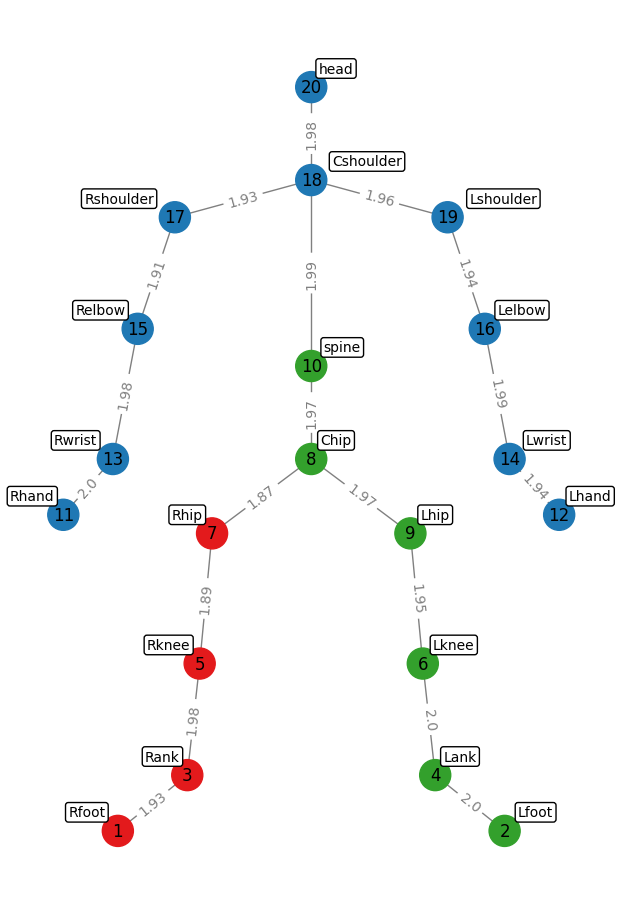

In [13]:
import networkx as nx
%matplotlib inline

jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

timeInstant = 0
featuresTable = velocityTable
#print(velocityTable)
# using angular momentum vector as feature
if isinstance(featuresTable.iloc[0,0],np.ndarray):
    tol = None
# using norm of either velocity / acceleration / energy as feature
else:
    tol = featuresTable.mean(axis=None) * 10**-3
    
weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol)
predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix,k=3)

# Create a graph using NetworkX from the adjacency matrix
graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

# Get edge labels from adjacency matrix (if present)
edge_labels = nx.get_edge_attributes(graph, "weight")
# Clip edge weights to the 2nd decimal place
for edge, weight in edge_labels.items():
    edge_labels[edge] = round(weight, 2)

# You can also create an undirected graph by using create_using=nx.Graph

pos = map_pos_human_body_graph()
# Create the colormap
# Define a pool of colors for k classes (you can add more colors if needed)
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']
#color_pool = ['#ff7777','#77ff77','#7777ff']

# Use the color pool to map cluster labels to colors
node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

fig = plt.figure(figsize=(6,9))
#canvas = fig.canvas
nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

# Create a custom legend for cluster labels
unique_labels = np.unique(predicted_labels)

# Create a custom legend for cluster labels using the color pool
legend_labels = {label: f"Cluster {label}" for label in unique_labels}
#plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label]) for label, color in zip(unique_labels, color_pool)], loc="upper right")


# Add annotations for joint names
for node, (x, y) in pos.items():
    plt.text(x+(np.sign(x) or True)*len(indxToPhys[node])*0.025, y+0.05, indxToPhys[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

#canvas.draw()
#image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
#image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
#from PIL import Image
#Image.fromarray(image).save("clustering1.png")

plt.show()

## Plotting skeleton with a slider to see default clusters evolution along times

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
featuresTable = angularMomentumTable
jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True


def update_graph(timeInstant):
    weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    
    graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
    graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i, node in enumerate(graph.nodes())})

    edge_labels = nx.get_edge_attributes(graph, "weight")
    for edge, weight in edge_labels.items():
        edge_labels[edge] = round(weight, 2)

    pos = map_pos_human_body_graph()

    node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

    plt.figure(figsize=(6, 9))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
    nx.draw_networkx_edge_labels(graph, pos,edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)
    plt.title(f"Time Instant: {timeInstant}")

    plt.show()


time_slider = widgets.IntSlider(min=0, max=(len(featuresTable) - 1), step=1, value=0, description='Time Instant:')
widgets.interact(update_graph, timeInstant=time_slider)

interactive(children=(IntSlider(value=0, description='Time Instant:', max=576), Output()), _dom_classes=('widg…

<function __main__.update_graph(timeInstant)>

# Minimum cost bipartite matching

In [15]:
from pandas import Series
from numpy import array, sum
from itertools import permutations
from typing import Literal
from networkx.algorithms.bipartite import minimum_weight_full_matching as min_wei_ful_match

def compute_cost(fromLabels:list,toLabels:list,labels_kind:Literal['full','cluster']='full'):
    if labels_kind == 'full':
        assert len(fromLabels) == len(toLabels)
        return sum(array(fromLabels) != array(toLabels))
    elif labels_kind =='cluster':
        return len(set(toLabels).difference(set(fromLabels)))
    raise Exception("method not implemented")

def clusterize_labels(labels:list): # assuming labels as list of integers going from 0 to n
    df = Series(labels)
    clusters = df.groupby(df).groups
    keys = set(clusters.keys())
    for i in range(max(keys)):
        if i not in keys:
            clusters[i] = []
    return clusters

def labelize_clusters(clusters:dict):
    clusterLabels = np.zeros(sum(len(nodes) for nodes in clusters.values()), dtype=int)
    for clusterLabel, indices in clusters.items():
        clusterLabels[indices] = clusterLabel
    return clusterLabels

def compute_minimum_weight_cluster(fromLabels:list,toLabels:list,method:Literal['BF','MWPM']="BF",visualize=False,return_relabeling=False) -> tuple :
    # Reassign labels 
    out_elements =[]
    if method.upper() == "BF":
        toClusters = clusterize_labels(toLabels)
        clusterLabelPermutations = list(permutations(list(toClusters.keys())))
        toClustersValues = list(toClusters.values())
        optimalLabelingIndex = -1
        minCost = 10**5
        if visualize:
            leftNodes = [0]
            rightNodes = list(range(1,len(clusterLabelPermutations)+1))
            plt.figure(figsize=(8,8))
            G = nx.DiGraph()
            G.add_nodes_from(leftNodes,bipartite=0,color='#1f78b4')
            G.add_nodes_from(rightNodes,bipartite=1,color='#33a02c')
            pos = nx.bipartite_layout(G,leftNodes)
            x_center = pos[leftNodes[0]][0]
            y_center = pos[leftNodes[0]][1]
            for node in rightNodes:
                angle = (2 * node * 3.14159) / len(rightNodes)  # Distribute the right nodes evenly around the center node
                distance = 2.0  # Adjust this value to control the distance of the right nodes from the center node
                x = x_center + distance * np.cos(angle)
                y = y_center + distance * np.sin(angle)
                pos[node] = (x, y)
            
        for indexPermutation,clusterLabelPermutation in enumerate(clusterLabelPermutations):
            permCost = compute_cost(fromLabels,labelize_clusters(dict(zip(clusterLabelPermutation,toClustersValues))))
            if visualize:
                G.add_edge(leftNodes[0],rightNodes[indexPermutation],weight=permCost,color='b',width=1)
            if permCost < minCost:
                optimalLabelingIndex = indexPermutation
                minCost = permCost
        if visualize:
            edgeColors = ['b' if i == optimalLabelingIndex else '#C4C2C6' for i in range(len(rightNodes))]
            edgeWidths = [3 if i == optimalLabelingIndex else 1 for i in range(len(rightNodes))]
            nx.draw(G, pos=pos,with_labels=True,node_size=900,node_color=list(nx.get_node_attributes(G, 'color').values()),edge_color=edgeColors,width=edgeWidths)
            nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), label_pos=0.5)
        out_elements.append(labelize_clusters(dict(zip(clusterLabelPermutations[optimalLabelingIndex],toClustersValues))))
        if return_relabeling:
            out_elements.append(clusterLabelPermutations[optimalLabelingIndex])
    elif method.upper() == 'MWPM':
        fromClustersMap = clusterize_labels(fromLabels)
        clusters = list(fromClustersMap.keys())
        toClustersUnlabelized = list(clusterize_labels(toLabels).values())
        rightNodes = (np.array(clusters) + max(clusters)+1).tolist()
        color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

        edgeWeights = {fromLabel : 
                            {toLabelAssigned+max(clusters)+1 : 
                                {'weight': compute_cost(fromClustersMap[fromLabel],toClustersUnlabelized[toLabelAssigned],labels_kind='cluster')}
                             for toLabelAssigned in clusters } 
                         for fromLabel in clusters }
        
        G = nx.from_dict_of_dicts(edgeWeights,create_using=nx.DiGraph)
        
        minWeightsEdges = {fromNode:toNode for fromNode, toNode in min_wei_ful_match(G,clusters,'weight').items() if fromNode not in rightNodes}
        reversedWeightsEdgesDict = {value:key for key,value in minWeightsEdges.items()}
        if visualize:
            plt.figure(figsize=(11,8))
            pos = nx.bipartite_layout(G, clusters)
            nx.draw(G, 
                    pos,
                    with_labels=True,
                    labels={elemFrom:elemFrom%len(clusters) for elemFrom in clusters+rightNodes}, 
                    node_size=1000, 
                    node_color= [color_pool[nodeId] for nodeId in clusters] +
                                [color_pool[reversedWeightsEdgesDict[toNodeId]] for toNodeId in sorted(reversedWeightsEdgesDict.keys())], 
                    font_size=10,
                    edge_color=[color_pool[edge[0]] if edge in list(minWeightsEdges.items()) else '#C4C2C6' for edge in G.edges()],
                    width=[3 if edge in list(minWeightsEdges.items()) else 1 for edge in G.edges()])
            nx.draw_networkx_edge_labels(G, 
                                         pos, 
                                         edge_labels=nx.get_edge_attributes(G, 'weight'),
                                         label_pos=0.85,
                                         font_size=10)#,
                                         #font_weight='bold')
            for node in G.nodes:
                text = list(fromClustersMap[node]) if node <= max(clusters) else list(toClustersUnlabelized[node-max(clusters)-1])
                text = list(map(str,text))
                text = '[ '+',\n'.join(', '.join(text[i:i+3]) for i in range(0, len(text), 3))+' ]'
                
                plt.text(pos[node][0], 
                         pos[node][1]+0.11, 
                         text,#str(list(fromClustersMap[node]))[1:-1] if node <= max(clusters) else str(list(toClustersUnlabelized[node-max(clusters)-1]))[1:-1], 
                         ha='center', 
                         va='center', 
                         color='black', 
                         fontsize=10,
                         fontweight='bold')
            #plt.suptitle('Minimum weight clusters',fontsize=14,fontweight='bold')
            plt.show()
        out_elements.append(labelize_clusters({fromNode: toClustersUnlabelized[minWeightsEdges[fromNode]-max(clusters)-1] for fromNode in minWeightsEdges.keys()}))
        if return_relabeling:
            out_elements.append({fromNode: minWeightsEdges[fromNode]-max(clusters)-1 for fromNode in minWeightsEdges.keys()})
    return out_elements if len(out_elements) > 1 else out_elements[0]



## Clustering results for the whole timeframe

2D mockup videos frame

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display

%matplotlib inline
featuresTable = angularMomentumTable
jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))

adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

def smooth_cluster_labels(timeInstant,prevLabels=None,draw=True,apply=True):
    weightMatrix = calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(weightMatrix)
    if prevLabels is not None and apply:
        predicted_labels = compute_minimum_weight_cluster(prevLabels,predicted_labels,'MWPM')
    
    if draw:
        graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
        graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i, node in enumerate(graph.nodes())})

        edge_labels = nx.get_edge_attributes(graph, "weight")
        for edge, weight in edge_labels.items():
            edge_labels[edge] = round(weight, 2)

        pos = map_pos_human_body_graph()

        node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

        clear_output(wait=True)  # This clears the previous plot
        fig = plt.figure(figsize=(6, 9))
        nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
        nx.draw_networkx_edge_labels(graph, pos,edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)
        plt.title(f"Time Instant: {timeInstant}")
        display(fig)  # This displays the updated plot
        plt.close(fig)
    return weightMatrix, predicted_labels

currLabels = None
for timeInstant in range(-len(featuresTable)):  # WARNING SET TO -len() to prevent rerunning each time
    _, currLabels = smooth_cluster_labels(timeInstant,currLabels)
    time.sleep(0.1)

fixedJointLabels = np.zeros((len(featuresTable)+1,20),dtype=int)
weightMatrices = np.zeros((len(allNodes),len(allNodes),len(featuresTable)))
for timeInstant in range(len(featuresTable)):
    weightMatrices[:,:,timeInstant], fixedJointLabels[timeInstant+1,:] = smooth_cluster_labels(timeInstant, fixedJointLabels[timeInstant] if timeInstant > 0 else None,draw=False)
fixedJointLabels = fixedJointLabels[1:,:]
originalJointLabels = np.zeros((len(featuresTable)+1,20),dtype=int)
for timeInstant in range(len(featuresTable)):
    _, originalJointLabels[timeInstant+1,:] = smooth_cluster_labels(timeInstant,originalJointLabels[timeInstant] if timeInstant > 0 else None,draw=False,apply=False)
originalJointLabels = originalJointLabels[1:,:]

/tmp/ipykernel_12925/1175670015.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  clusterLabels = np.zeros(sum(len(nodes) for nodes in clusters.values()), dtype=int)
/tmp/ipykernel_12925/1175670015.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  clusterLabels = np.zeros(sum(len(nodes) for nodes in clusters.values()), dtype=int)
/tmp/ipykernel_12925/1175670015.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  clusterLabels = np.zeros(sum(len(nodes) for nodes in clusters.values()), dtype=int)
/tmp/ipykernel_12925/1175670015.py:25: DeprecationWarning: Calling np.sum(generator) is 

In [17]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


plt.close("all")
fig = plt.figure()
ax:plt.Axes = fig.add_subplot(111, projection='3d')


minMax = np.zeros((2,3))
minMax[0,:] = [posTableX.values.min(),posTableY.values.min(),posTableZ.values.min()]
minMax[1,:] = [posTableX.values.max(),posTableY.values.max(),posTableZ.values.max()]

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the window title
fig.canvas.manager.window.title("3D Movement with clusters\t(Scroll with mouse wheel)")

# Set the initial time index
time_index = 0
jointColors = np.vectorize(lambda joint: color_pool[joint])(fixedJointLabels)

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = posTableX.iloc[val]
    filteredY = posTableY.iloc[val]
    filteredZ = posTableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ,c=jointColors[val,:])

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Movement "+str(sampleAnno))

    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
maxValue = posTable.shape[0]-1
slider = Slider(slider_ax, 'TimeIndex:', 0, maxValue, valinit=time_index, valstep=1)


# Define a function to update the slider value with the mouse wheel
def on_scroll(event):
    if event.button == 'down':
        if slider.val + slider.valstep*2 <= maxValue:
            slider.set_val(slider.val + slider.valstep*2)
    elif event.button == 'up':
        if slider.val - slider.valstep*2 >= 0:
            slider.set_val(slider.val - slider.valstep*2)
        

# Connect the mouse wheel event to the function
fig.canvas.mpl_connect('scroll_event', on_scroll)


# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg


#### Static

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output, display
import time

# Color pool
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

plt.close("all")
fig = plt.figure(figsize=(13,13))
ax: plt.Axes = fig.add_subplot(111, projection='3d')

minMax = np.zeros((2, 3))
minMax[0, :] = [posTableX.values.min(), posTableY.values.min(), posTableZ.values.min()]
minMax[1, :] = [posTableX.values.max(), posTableY.values.max(), posTableZ.values.max()]

ax.set_xlim([minMax[0, 0], minMax[1, 0]])
ax.set_ylim([minMax[0, 1], minMax[1, 1]])
ax.set_zlim([minMax[0, 2], minMax[1, 2]])

#fig.canvas.manager.window.title("3D Movement with clusters\t(Scroll with mouse wheel)")

time_indices = range(posTableX.shape[0])
jointColors = np.vectorize(lambda joint: color_pool[joint])(fixedJointLabels)

# Loop through each time instant and plot results
for time_index in range(-len(posTable)):       # MODIFY TO ENABLE REMOVING THE MINUS
    clear_output(wait=True)
    ax.cla()

    filteredX = posTableX.iloc[time_index]
    filteredY = posTableY.iloc[time_index]
    filteredZ = posTableZ.iloc[time_index]

    ax.scatter(filteredX, filteredY, filteredZ, c=jointColors[time_index, :])

    ax.set_xlim([minMax[0, 0], minMax[1, 0]])
    ax.set_ylim([minMax[0, 1], minMax[1, 1]])
    ax.set_zlim([minMax[0, 2], minMax[1, 2]])

    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Time instant: " + str(time_index))

    display(fig)
    
    time.sleep(0.01)  # Add a delay to control animation speed

plt.close(fig)

#### With arcs

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output, display
import time

# Color pool
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

plt.close("all")
fig = plt.figure(figsize=(15, 15))
ax: plt.Axes = fig.add_subplot(111, projection='3d')

minMax = np.zeros((2, 3))
minMax[0, :] = [posTableX.values.min(), posTableY.values.min(), posTableZ.values.min()]
minMax[1, :] = [posTableX.values.max(), posTableY.values.max(), posTableZ.values.max()]

ax.set_xlim([minMax[0, 0], minMax[1, 0]])
ax.set_ylim([minMax[0, 1], minMax[1, 1]])
ax.set_zlim([minMax[0, 2], minMax[1, 2]])

time_indices = range(-len(posTableX))
fixedJointColors = np.vectorize(lambda joint: color_pool[joint])(fixedJointLabels)
originalJointColors = np.vectorize(lambda joint: color_pool[joint])(originalJointLabels)

# Loop through each time instant and plot results
for time_index in range(-len(posTableX)):  # MODIFY TO ENABLE REMOVING THE MINUS
    clear_output(wait=True)
    ax.cla()

    filteredX = posTableX.iloc[time_index]
    filteredY = posTableY.iloc[time_index]
    filteredZ = posTableZ.iloc[time_index]

    ax.scatter(filteredX, filteredY, filteredZ, c=fixedJointColors[time_index, :],alpha=1,s=100)

    ax.set_xlim([minMax[0, 0], minMax[1, 0]])
    ax.set_ylim([minMax[0, 1], minMax[1, 1]])
    ax.set_zlim([minMax[0, 2], minMax[1, 2]])

    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)
    #ax.set_zlabel('Z', fontsize=12)
    #ax.set_title("optimal clustering at t = " + str(time_index))

    # Add edges based on the weight matrix
    for i in range(20):
        for j in range(i + 1, 20):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='gray', linestyle='-', linewidth=1)
                #ax.text((filteredX[i]+filteredX[j])/2, (filteredY[i]+filteredY[j])/2, (filteredZ[i]+filteredZ[j])/2, str(weightMatrices[i,j,time_index])[:5], horizontalalignment='center',fontsize=8, color='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.grid(True)
    ax.view_init(elev=20, azim=-72)
    display(fig)
    time.sleep(0.01)

plt.close(fig)

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output, display
import time

# Color pool
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

plt.close("all")
fig = plt.figure(figsize=(15, 15))
ax: plt.Axes = fig.add_subplot(111, projection='3d')

minMax = np.zeros((2, 3))
minMax[0, :] = [posTableX.values.min(), posTableY.values.min(), posTableZ.values.min()]
minMax[1, :] = [posTableX.values.max(), posTableY.values.max(), posTableZ.values.max()]

ax.set_xlim([minMax[0, 0], minMax[1, 0]])
ax.set_ylim([minMax[0, 1], minMax[1, 1]])
ax.set_zlim([minMax[0, 2], minMax[1, 2]])

fixedJointColors = np.vectorize(lambda joint: color_pool[joint])(fixedJointLabels)
originalJointColors = np.vectorize(lambda joint: color_pool[joint])(originalJointLabels)

# Loop through each time instant and plot results
for time_index in range(-1):#[109, 138]:#range(138,140):#len(posTableX)):  # MODIFY TO ENABLE REMOVING THE MINUS
    #clear_output(wait=True)
    ax.cla()

    filteredX = posTableX.iloc[time_index]
    filteredY = posTableY.iloc[time_index]
    filteredZ = posTableZ.iloc[time_index]

    ax.scatter(filteredX, filteredY, filteredZ, c=fixedJointColors[time_index, :],alpha=1,s=100)

    ax.set_xlim([minMax[0, 0], minMax[1, 0]])
    ax.set_ylim([minMax[0, 1], minMax[1, 1]])
    ax.set_zlim([minMax[0, 2], minMax[1, 2]])

    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)
    #ax.set_zlabel('Z', fontsize=12)
    ax.set_title("frame number = " + str(time_index),fontsize=30,y=1)

    # Add edges based on the weight matrix
    for i in range(20):
        for j in range(i + 1, 20):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='gray', linestyle='-', linewidth=1.5)
                #ax.text((filteredX[i]+filteredX[j])/2, (filteredY[i]+filteredY[j])/2, (filteredZ[i]+filteredZ[j])/2, str(weightMatrices[i,j,time_index])[:5], horizontalalignment='center',fontsize=8, color='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.grid(True)
    ax.view_init(elev=20, azim=-80)
    display(fig)

    time.sleep(0.05)  # Add a delay to control animation speed


# Loop through each time instant and plot results
for time_index in range(-1):#[138]:#range(139,140):#len(posTableX)):  # MODIFY TO ENABLE REMOVING THE MINUS
    #clear_output(wait=True)
    ax.cla()

    filteredX = posTableX.iloc[time_index]
    filteredY = posTableY.iloc[time_index]
    filteredZ = posTableZ.iloc[time_index]

    ax.scatter(filteredX, filteredY, filteredZ, c=originalJointColors[time_index, :],alpha=1,s=100)

    ax.set_xlim([minMax[0, 0], minMax[1, 0]])
    ax.set_ylim([minMax[0, 1], minMax[1, 1]])
    ax.set_zlim([minMax[0, 2], minMax[1, 2]])

    #ax.set_xlabel('X', fontsize=12)
    #ax.set_ylabel('Y', fontsize=12)
    #ax.set_zlabel('Z', fontsize=12)
    ax.set_title("frame number = " + str(time_index),fontsize=30,y=1)

    # Add edges based on the weight matrix
    for i in range(20):
        for j in range(i + 1, 20):
            if adjacencyMatrix[i,j]:
                ax.plot([filteredX[i], filteredX[j]],
                        [filteredY[i], filteredY[j]],
                        [filteredZ[i], filteredZ[j]],
                        color='gray', linestyle='-', linewidth=1.5)
                #ax.text((filteredX[i]+filteredX[j])/2, (filteredY[i]+filteredY[j])/2, (filteredZ[i]+filteredZ[j])/2, str(weightMatrices[i,j,time_index])[:5], horizontalalignment='center',fontsize=8, color='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.grid(True)
    ax.view_init(elev=20, azim=-80)
    display(fig)

    
    time.sleep(0.05)  # Add a delay to control animation speed


plt.close(fig)


#### Rotating

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output, display
import time

# Color pool
color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

plt.close("all")
fig = plt.figure(figsize=(13, 13))
ax: plt.Axes = fig.add_subplot(111, projection='3d')

minMax = np.zeros((2, 3))
minMax[0, :] = [posTableX.values.min(), posTableY.values.min(), posTableZ.values.min()]
minMax[1, :] = [posTableX.values.max(), posTableY.values.max(), posTableZ.values.max()]

ax.set_xlim([minMax[0, 0], minMax[1, 0]])
ax.set_ylim([minMax[0, 1], minMax[1, 1]])
ax.set_zlim([minMax[0, 2], minMax[1, 2]])

# Initialize rotation angle
theta = 0

time_indices = range(len(posTableX))
jointColors = np.vectorize(lambda joint: color_pool[joint])(fixedJointLabels)

# Loop through each time instant and plot results
for time_index in range(-len(posTableX)):   # MODIFY TO ENABLE REMOVING THE MINUS
    clear_output(wait=True)
    ax.cla()

    filteredX = posTableX.iloc[time_index]
    filteredY = posTableY.iloc[time_index]
    filteredZ = posTableZ.iloc[time_index]

    ax.scatter(filteredX, filteredY, filteredZ, c=jointColors[time_index, :])

    ax.set_xlim([minMax[0, 0], minMax[1, 0]])
    ax.set_ylim([minMax[0, 1], minMax[1, 1]])
    ax.set_zlim([minMax[0, 2], minMax[1, 2]])

    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Time instant: " + str(time_index))

    # Update the view by rotating the plot by theta angle
    ax.view_init(elev=20, azim=theta)
    theta += 1  # Increase the angle for the next frame

    display(fig)
    
    time.sleep(0.05)  # Add a delay to control animation speed

plt.close(fig)


# Auxiliary graph
| Function                             | Input                                  | Output             | Explanation                                                                                                                      |
|--------------------------------------|----------------------------------------|--------------------|----------------------------------------------------------------------------------------------------------------------------------|
| `compute_auxiliary_graph` | featureVector (pd.DataFrame), clusters (np.ndarray), adjacencyMatrix (np.ndarray) | auxiliary_graph (np.ndarray) | Computes the auxiliary graph for both scalar and vectorial features based on the provided feature vector, clusters, and adjacency matrix. The *featureVector* is assumed to be a 1 time instant by 20 joints. The clusters a 1-D array that contains the clustering results for each joint. The adjacencyMatrix is a square matrix that represents connections between joints. The function calculates the norm of differences (in our case just modulus since features are scalar) between feature vectors for each pair of joints. Then, it sets the values in the auxiliary graph based on the adjacency matrix and cluster condition. If there is a connection between two joints (*adjacencyMatrix[i, j] = 1*) and the joints belong to different clusters (*clusters[i] != clusters[j]*), the corresponding element in the auxiliary graph is set to the absolute difference between their feature vectors otherwise to 0. *auxiliary_graph* has same dimensions as *adjacency_matrix*. For angular momentum uses the norm of the differences. |


In [22]:
import numpy as np
import pandas as pd
def compute_auxiliary_graph(featuresTable:pd.DataFrame,clusters:np.ndarray,adjacencyMatrix:np.ndarray) -> np.ndarray:
    auxiliary_graph = np.zeros(adjacencyMatrix.shape)
    if isinstance(featuresTable.iloc[0],np.ndarray):
        vectorsArray = np.stack(featuresTable.values)
        normMatrix = np.linalg.norm(vectorsArray[:,None] - vectorsArray, axis=2)
    else:
        normMatrix = np.abs(featuresTable.values[:,None] - featuresTable.values)
    mask = np.logical_and(adjacencyMatrix,clusters[:,None] != clusters)
    auxiliary_graph[mask] = normMatrix[mask]
    return auxiliary_graph

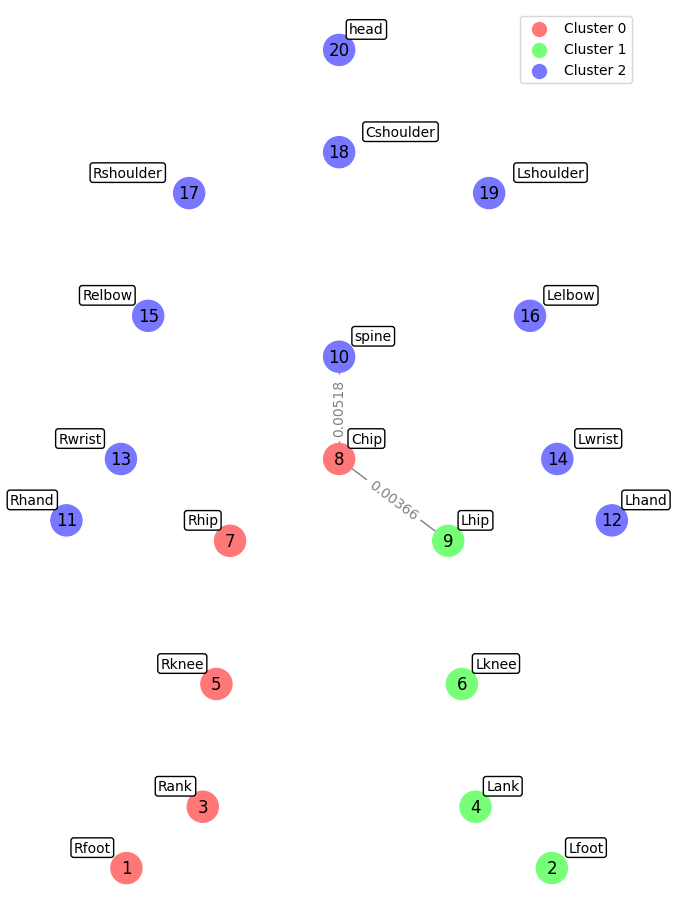

max shapley edge: 		Lelbow - Lshoulder (16, 19)
second max shapley edge: 	Rshoulder - Cshoulder (17, 18)
OoM [18-20]
+-----------+---------+---------+--------+--------+---------+---------+--------+--------+--------+---------+---------+---------+----------+----------+----------+----------+-------------+-------------+-------------+--------+
|           |   Rfoot |   Lfoot |   Rank |   Lank |   Rknee |   Lknee |   Rhip |   Chip |   Lhip |   spine |   Rhand |   Lhand |   Rwrist |   Lwrist |   Relbow |   Lelbow |   Rshoulder |   Cshoulder |   Lshoulder |   head |
+===========+=========+=========+========+========+=========+=========+========+========+========+=========+=========+=========+==========+==========+==========+==========+=============+=============+=============+========+
| Rfoot     |       0 |       0 | 0      | 0      |  0      |  0      | 0      | 0      | 0      |  0      |       0 |       0 |   0      |        0 |   0      |   0      |      0      |      0      |      0    

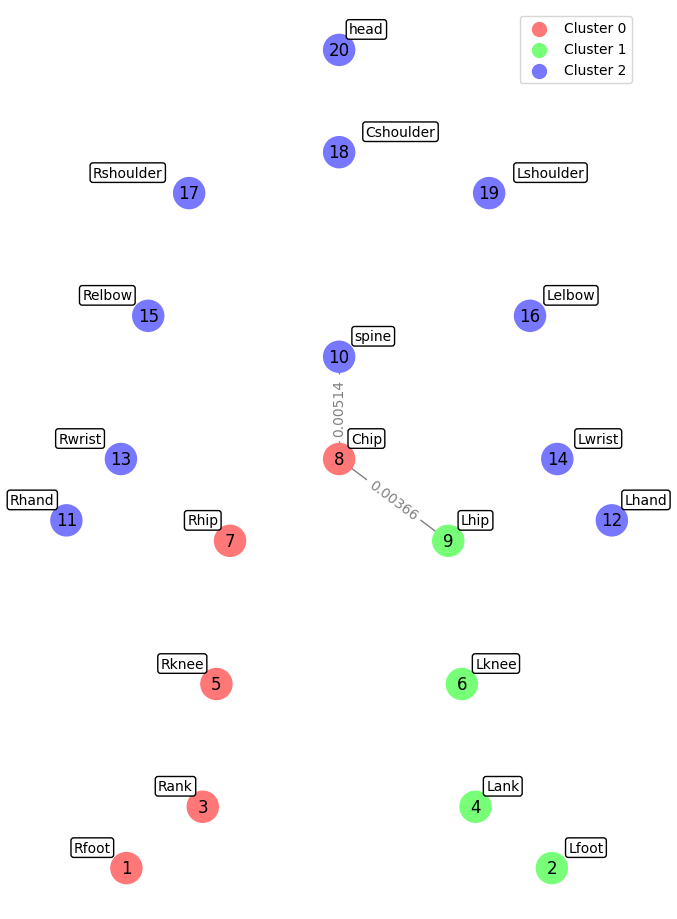

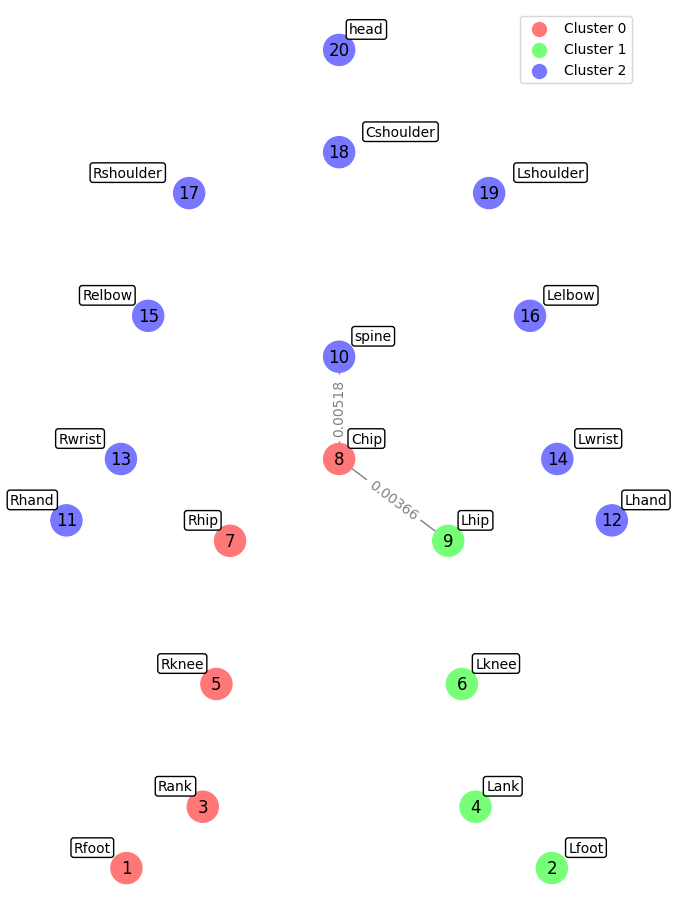

In [23]:
import networkx as nx
from IPython.display import clear_output, display
import time
from tabulate import tabulate
%matplotlib inline

jointsFrom = [1, 3, 5, 2, 4, 6, 7, 8, 8,10,11,13,15,17,12,14,16,18,18]
jointsTo =   [3, 5, 7, 4, 6, 9, 8, 9,10,18,13,15,17,18,14,16,19,19,20]

allNodes = set(jointsFrom).union(set(jointsTo))
jointsFrom = list(map(lambda x: x-1,jointsFrom))
jointsTo = list(map(lambda x: x-1,jointsTo))
edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))
adjacencyMatrix = np.zeros((20,20),dtype=bool)
adjacencyMatrix[edges[:,0],edges[:,1]] = True

timeInstant = 1
featuresTable = angularMomentumTable

# using angular momentum vector as feature
if isinstance(featuresTable.iloc[0,0],np.ndarray):
    tol = None
# using norm of either velocity / acceleration / energy as feature
else:
    tol = featuresTable.mean(axis=None) * 10**-3

for timeInstant in range(2):#-len(posTable)):
    clear_output(wait=True)
    time.sleep(0.5)
    predicted_labels = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol),k=3)
    weightMatrix = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)
    # Create a graph using NetworkX from the adjacency matrix
    graph = nx.from_numpy_array(np.multiply(adjacencyMatrix,weightMatrix))
    graph = nx.relabel_nodes(graph, {node: list(allNodes)[i] for i,node in enumerate(graph.nodes())})

    # Get edge labels from adjacency matrix (if present)
    edge_labels = nx.get_edge_attributes(graph, "weight")
    # Clip edge weights to the 2nd decimal place
    for edge, weight in edge_labels.items():
        edge_labels[edge] = round(weight, 5)

    # You can also create an undirected graph by using create_using=nx.Graph

    pos = map_pos_human_body_graph()
    # Create the colormap
    # Define a pool of colors for k classes (you can add more colors if needed)
    color_pool = ['#e31a1c', '#1f78b4', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']
    color_pool = ['#ff7777','#77ff77','#7777ff']

    # Use the color pool to map cluster labels to colors
    node_colors = [color_pool[label % len(color_pool)] for label in predicted_labels]

    fig = plt.figure(figsize=(6,9))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, edge_color="gray")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10, font_color='gray', label_pos=0.5)

    # Create a custom legend for cluster labels
    unique_labels = np.unique(predicted_labels)

    # Create a custom legend for cluster labels using the color pool
    legend_labels = {label: f"Cluster {label}" for label in unique_labels}
    plt.legend(handles=[plt.scatter([], [], s=100, c=color, marker='o', label=legend_labels[label]) for label, color in zip(unique_labels, color_pool)], loc="upper right")


    # Add annotations for joint names
    for node, (x, y) in pos.items():
        plt.text(x+(np.sign(x) or True)*len(indxToPhys[node])*0.025, y+0.05, indxToPhys[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    #plt.title(f"Auxiliary Graph of frame: {timeInstant+1} / {len(posTable)}")

    display(fig)
    #plt.show()


import warnings

# Suppress complex warning
warnings.filterwarnings("ignore", category=Warning)
weightMatrix = np.zeros((20,20,len(posTable)))
maxWeightMatrix = np.zeros((20,20))
for timeInstant in range(len(posTable)):
    predicted_labels = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol))
    weightMatrix[:,:,timeInstant] = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)
    for i in range(weightMatrix.shape[0]):
        for j in range(weightMatrix.shape[1]):
            if maxWeightMatrix[i,j] < weightMatrix[i,j,timeInstant]:
                maxWeightMatrix[i,j] = np.round(weightMatrix[i,j,timeInstant],decimals=4)
max_index = np.unravel_index(np.argmax(maxWeightMatrix), maxWeightMatrix.shape)
print(f"max shapley edge: \t\t{indxToPhys[max_index[0]+1]} - {indxToPhys[max_index[1]+1]} {(max_index[0]+1,max_index[1]+1)}")
maxWeightMatrix_copy = maxWeightMatrix.copy()
maxWeightMatrix_copy[max_index[0],max_index[1]] = -1.
maxWeightMatrix_copy[max_index[1],max_index[0]] = -1.
max_index = np.unravel_index(np.argmax(maxWeightMatrix_copy), maxWeightMatrix.shape)
print(f"second max shapley edge: \t{indxToPhys[max_index[0]+1]} - {indxToPhys[max_index[1]+1]} {(max_index[0]+1,max_index[1]+1)}")
print(f'OoM {OoM}')

headers = [ ' ',
    "Rfoot", "Lfoot", "Rank", "Lank", "Rknee", "Lknee", "Rhip", "Chip", "Lhip", "spine", "Rhand", "Lhand",
    "Rwrist", "Lwrist", "Relbow", "Lelbow", "Rshoulder", "Cshoulder", "Lshoulder", "head"
]

data = [[headers[i+1]] for i in range(20)]
for i in range(20):
    for j in range(20):
        data[i].append(maxWeightMatrix[i,j])

table = tabulate(data, headers, tablefmt="grid")

print(table)

### Shapley Values

In [24]:
import numpy as np
def calculate_shapley_values(auxiliaryGraph:np.ndarray):
    shapleys = 0.5 * np.sum(auxiliaryGraph,axis=1)
    maxShapley = np.max(shapleys)
    utilityNormFactor = np.sum(shapleys)
    return shapleys, shapleys / maxShapley, shapleys / utilityNormFactor # should also return mean across every time instant

In [25]:
max_joint = np.argmax(calculate_shapley_values(maxWeightMatrix)[0])
max_joint_name = indxToPhys[max_joint+1]
maxWeightMatrix_copy = maxWeightMatrix.copy()
maxWeightMatrix_copy[max_joint,:] = 0.
second_max_joint = np.argmax(calculate_shapley_values(maxWeightMatrix_copy)[0])
second_max_joint_name = indxToPhys[second_max_joint+1]

print("Absolute maxes:",max_joint_name, f'({max_joint})', second_max_joint_name, f'({second_max_joint})')
print(f'OoM {OoM}')

Absolute maxes: Cshoulder (17) Lshoulder (18)
OoM [18-20]


In [26]:
ooms = []
for timeInstant in range(len(posTable)):
    ooms.append(np.argmax(calculate_shapley_values(weightMatrix[:,:,timeInstant])[0]))
    weightMatrix_copy = weightMatrix[:,:,timeInstant].copy()
    weightMatrix_copy[np.unravel_index(np.argmax(weightMatrix_copy), maxWeightMatrix.shape)] = -1.
    ooms.append(np.argmax(calculate_shapley_values(weightMatrix_copy)[0]))

from collections import Counter

sorted_counts = sorted(Counter(ooms).items(), key=lambda x: x[1], reverse=True)
print("Cumulative maxes: ")
for element, count in sorted_counts:
    print(f"Element {indxToPhys[element+1]} ({element}) occurs {count} times.")

Cumulative maxes: 
Element Lshoulder (18) occurs 277 times.
Element Lelbow (15) occurs 270 times.
Element Rshoulder (16) occurs 179 times.
Element Relbow (14) occurs 137 times.
Element Lknee (5) occurs 73 times.
Element Cshoulder (17) occurs 72 times.
Element Lhip (8) occurs 71 times.
Element Rwrist (12) occurs 17 times.
Element Rknee (4) occurs 14 times.
Element spine (9) occurs 14 times.
Element Chip (7) occurs 12 times.
Element Rank (2) occurs 7 times.
Element Rhip (6) occurs 7 times.
Element Lank (3) occurs 4 times.


In [27]:
import warnings
from tabulate import tabulate

# Suppress complex warning
warnings.filterwarnings("ignore", category=Warning)
weightMatrix = np.zeros((20,20,len(posTable)))
maxWeightMatrix = np.zeros((20,20))
for timeInstant in range(len(posTable)):
    predicted_labels = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol))
    weightMatrix[:,:,timeInstant] = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)
    for i in range(weightMatrix.shape[0]):
        for j in range(weightMatrix.shape[1]):
            maxWeightMatrix[i,j] += weightMatrix[i,j,timeInstant]
max_index = np.unravel_index(np.argmax(maxWeightMatrix), maxWeightMatrix.shape)
print(f"max shapley edge: \t\t{indxToPhys[max_index[0]+1]} - {indxToPhys[max_index[1]+1]} {(max_index[0]+1,max_index[1]+1)}")
maxWeightMatrix_copy = maxWeightMatrix.copy()
maxWeightMatrix_copy[max_index[0],max_index[1]] = -1.
maxWeightMatrix_copy[max_index[1],max_index[0]] = -1.
max_index = np.unravel_index(np.argmax(maxWeightMatrix_copy), maxWeightMatrix.shape)
print(f"second max shapley edge: \t{indxToPhys[max_index[0]+1]} - {indxToPhys[max_index[1]+1]} {(max_index[0]+1,max_index[1]+1)}")
print(f'OoM {OoM}')

headers = ['']+[indxToPhys[i+1] for i in range(20)]

data = [[headers[i+1]] for i in range(20)]
for i in range(20):
    for j in range(20):
        data[i].append(maxWeightMatrix[i,j])

table = tabulate(data, headers, tablefmt="grid")

print(table)

max shapley edge: 		Lelbow - Lshoulder (16, 19)
second max shapley edge: 	Chip - spine (8, 10)
OoM [18-20]
+-----------+---------+---------+-----------+----------+-----------+----------+----------+----------+----------+----------+---------+---------+----------+----------+----------+----------+-------------+-------------+-------------+--------+
|           |   Rfoot |   Lfoot |      Rank |     Lank |     Rknee |    Lknee |     Rhip |     Chip |     Lhip |    spine |   Rhand |   Lhand |   Rwrist |   Lwrist |   Relbow |   Lelbow |   Rshoulder |   Cshoulder |   Lshoulder |   head |
+===========+=========+=========+===========+==========+===========+==========+==========+==========+==========+==========+=========+=========+==========+==========+==========+==========+=============+=============+=============+========+
| Rfoot     |       0 |       0 | 0         | 0        | 0         | 0        | 0        | 0        | 0        | 0        |       0 |       0 | 0        |        0 | 0        |

# Clustering Results Summarization
Smarmella

In [36]:
import pandas as pd
import numpy as np
import os
from typing import Literal
from tqdm.notebook import tqdm
#from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from collections import Counter

ANNOTATIONS_PATH = 'data'
REPROCESSED_PATH = ANNOTATIONS_PATH+'/reprocessed'
with open(ANNOTATIONS_PATH+'/annotationsVSingle.txt','r') as file:
    annotations = file.read().splitlines()[1:]

def get_adjacency_matrix():
    jointsFrom = [1, 3, 5, 7, 2, 4, 6, 9, 8,10,11,13,15,17,12,14,16,19,18]
    jointsTo =   [3, 5, 7, 8, 4, 6, 9, 8,10,18,13,15,17,18,14,16,19,18,20]
    jointsFrom = list(map(lambda x: x-1,jointsFrom))
    jointsTo = list(map(lambda x: x-1,jointsTo))
    edges = np.array(list(zip(jointsFrom,jointsTo))+list(zip(jointsTo,jointsFrom)))
    adjacencyMatrix = np.zeros((20,20),dtype=bool)
    adjacencyMatrix[edges[:,0],edges[:,1]] = True
    return adjacencyMatrix

def compute_clustering_comparison(sampleAnno, method: Literal['aux_max_cumulative','shapley_max_cumulative','aux_max_overall','shapley_max_overall']='shapley_max_cumulative',return_sample_score=False):
    '''
    Only shapley_max_cumulative has been used because it's the most accurate
    '''
    if '(A)' in annotations[sampleAnno] or '(B)' in annotations[sampleAnno]:
        folder, trial, fragId, _, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:7]
    else:
        folder, trial, fragId, OoM, startSec, endSec = annotations[sampleAnno].replace(' ','').split(',')[:6]
    OoM = tuple(map(int, OoM.strip('[]').split('-')))
    file = os.path.join(REPROCESSED_PATH, folder, trial+'_frag'+fragId+'.csv')
    posTable = pd.read_csv(file)
    dt = ((float(endSec)-float(startSec)) / len(posTable))
    velocityTable = compute_derivatives(posTable,dt)
    velocityTable = group_table_by_joints(velocityTable).applymap(lambda x: np.linalg.norm(x))
    centerOfMassPosTable = pd.concat([table.apply(lambda row: row.sum()/20,axis=1) for table in table_to_list_xyz_tables(posTable)],axis=1)
    relativePosTable = group_table_by_joints(xyz_tables_to_xyz_columns([posTableAxis.subtract(centerOfMassPosTable.iloc[:,j],axis=0) for j,posTableAxis in enumerate(table_to_list_xyz_tables(posTable))]))
    centerOfMassVelocityTable = compute_derivatives(centerOfMassPosTable,dt,smooth=False)
    relativeVelocityTable = group_table_by_joints(xyz_tables_to_xyz_columns([velocityTableAxis.subtract(centerOfMassVelocityTable.iloc[:,j],axis=0) for j,velocityTableAxis in enumerate(table_to_list_xyz_tables(compute_derivatives(posTable,dt)))]))
    angularMomentumTable = relativePosTable
    for i in range(len(relativePosTable)):
        for j in range(len(relativePosTable.columns)):
            angularMomentumTable.iloc[i,j][:] = np.cross(relativePosTable.iloc[i,j],relativeVelocityTable.iloc[i,j])
    angularMomentumTable = group_table_by_joints(smoothing(joints_array_to_xyz_columns(angularMomentumTable)))
    accelerationTable = compute_derivatives(velocityTable,dt)

    featuresTable = angularMomentumTable
    # using angular momentum vector as feature
    if isinstance(featuresTable.iloc[0,0],np.ndarray):
        tol = None
    # using norm of either velocity / acceleration / energy as feature
    else:
        tol = featuresTable.mean(axis=None) * 10**-3

    weightMatrix = np.zeros((20,20,len(posTable)))
    #maxWeightMatrix = np.zeros((len(allNodes),len(allNodes)))
    #maxWeightMatrixOverall = np.zeros((len(allNodes),len(allNodes)))
    #maxShapleys = {node:0 for node in allNodes}
    best_shapleys = []
    for timeInstant in range(len(posTable)):
        predicted_labels = shi_malik_spectral_clustering_matlab_version(calculate_weight_matrix(featuresTable.iloc[timeInstant],adjacencyMatrix,tol))
        weightMatrix[:,:,timeInstant] = compute_auxiliary_graph(featuresTable.iloc[timeInstant],predicted_labels,adjacencyMatrix)
        #if method == 'aux_max_overall':
        #    for i in range(weightMatrix.shape[0]):
        #        for j in range(weightMatrix.shape[1]):
        #            if maxWeightMatrix[i,j] < weightMatrix[i,j,timeInstant]:
        #                maxWeightMatrix[i,j] = np.round(weightMatrix[i,j,timeInstant],decimals=4)
        #if method == 'shapley_max_cumulative':
        best_shapleys.append(np.argmax(calculate_shapley_values(weightMatrix[:,:,timeInstant])[0]))
        weightMatrix_copy = weightMatrix[:,:,timeInstant].copy()
        weightMatrix_copy[np.unravel_index(np.argmax(weightMatrix_copy), weightMatrix_copy.shape)] = -1.
        best_shapleys.append(np.argmax(calculate_shapley_values(weightMatrix_copy)[0]))
        if timeInstant == len(posTable)-1:
            top_two_shapleys = list(zip(*list(sorted(Counter(best_shapleys).items(), key=lambda x: x[1], reverse=True))[:2]))[0]
    if return_sample_score:
        score = 0
        for timeInstant in range(len(posTable)):
            found = False
            if top_two_shapleys[0] in OoM:
                found = True
                OoM_shapley = top_two_shapleys[0]
            elif top_two_shapleys[1] in OoM:
                found = True
                OoM_shapley = top_two_shapleys[1]
            if found:
                is_this_shapley_OoM = np.argmax(calculate_shapley_values(weightMatrix[:,:,timeInstant])) == OoM_shapley
                if is_this_shapley_OoM: score += 1
                else:
                    weightMatrix_copy = weightMatrix[:,:,timeInstant].copy()
                    weightMatrix_copy[np.unravel_index(np.argmax(weightMatrix_copy), weightMatrix_copy.shape)] = -1.
                    score += int(np.argmax(calculate_shapley_values(weightMatrix_copy)[0]) == OoM_shapley)
        return score/len(posTable)

        #if method == 'shapley_max_overall':
        #    shapleys = calculate_shapley_values(weightMatrix[:,:,timeInstant])[0]
        #    maxShapleys[np.argmax(shapleys)] = max(np.max(shapleys),maxShapleys[np.argmax(shapleys)])
        #    shapleys[np.argmax(shapleys)] = -1.
        #    maxShapleys[np.argmax(shapleys)] = max(np.max(shapleys),maxShapleys[np.argmax(shapleys)])

        #if method == 'aux_max_cumulative':
        #    for i in range(weightMatrix.shape[0]):
        #        for j in range(weightMatrix.shape[1]):
        #            maxWeightMatrixOverall[i,j] += weightMatrix[i,j,timeInstant]
    if method == 'shapley_max_cumulative':
        return any(node in OoM for node in top_two_shapleys)
        #elif method == 'aux_max_cumulative':
        #    return any(node in OoM for node in np.unravel_index(np.argmax(maxWeightMatrixOverall), maxWeightMatrixOverall.shape))
        #elif method == 'shapley_max_overall':
        #    return any(node in OoM for node,_ in list(sorted(maxShapleys.items(),key=lambda x: x[1],reverse=True))[:2])
        #return any(node in OoM for node in np.unravel_index(np.argmax(maxWeightMatrix), maxWeightMatrix.shape))

adjacencyMatrix = get_adjacency_matrix()
accuracy = 0

with multiprocessing.Pool(processes=4) as pool:
    accuracy = list(tqdm(pool.imap(compute_clustering_comparison, range(len(annotations))), total=len(annotations), desc="Computing algorithmic method accuracy: "))
#for i in tqdm(range(len(annotations)),'Calculating shapleys accuracy'):
#    accuracy += int(compute_clustering_comparison(i))
print(accuracy)
#print(sum(accuracy) / len(annotations))

Computing algorithmic method accuracy:   0%|          | 0/60 [00:00<?, ?it/s]

[True, True, False, True, False, True, True, True, False, False, True, False, False, False, True, False, False, False, True, True, False, False, True, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, True, True, False, False, False, True, True, False, False, False, True, False, False, False, True, True, True]


In [37]:
print(sum(accuracy) / len(annotations))

0.36666666666666664


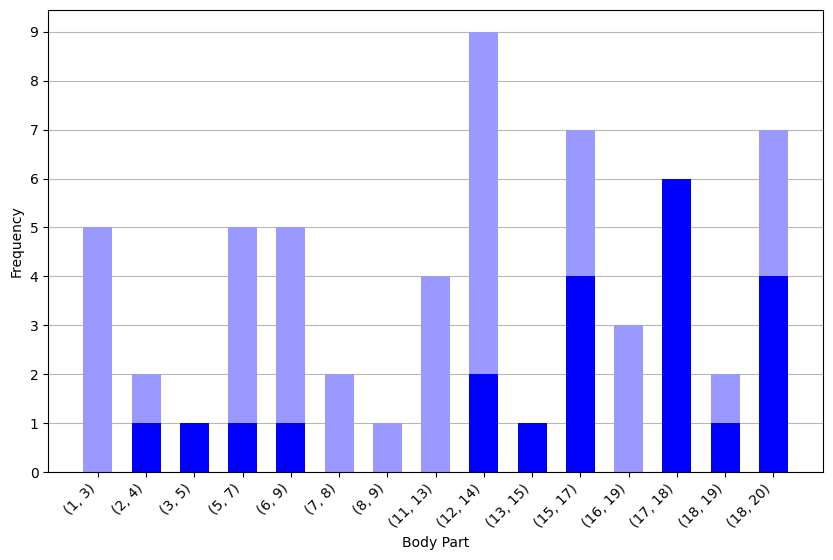

In [38]:
from collections import Counter

all_ooms = []
x_labels = []
for i,sample in enumerate(annotations):
    if '(A)' in sample or '(B)' in sample:
        folder, trial, fragId, _, OoM, startSec, endSec = sample.replace(' ','').split(',')[:7]
    else:
        folder, trial, fragId, OoM, startSec, endSec = sample.replace(' ','').split(',')[:6]
    OoM = tuple(map(int, OoM.strip('[]').split('-')))
    x_labels.append(OoM)
    all_ooms.append(OoM if accuracy[i] else (-1,-1))

y_labels = [count for _,count in sorted(Counter(x_labels).items())]
x_labels = sorted(set(x_labels))
y_wdc = []
for x in x_labels:
    for value, count in sorted(Counter(all_ooms).items())[1:]:
        if x < value or (value != x and value == list(sorted(Counter(all_ooms).items())[1:])[-1][0]):
            count = 0
            break
        elif x == value:
            break
    y_wdc.append(count)


plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='-', axis='y',alpha=0.7,c=(0.6,0.6,0.6))
#plt.axhline(average, color='blue', linestyle='--', zorder=0)
plt.bar(range(0,len(x_labels)), y_labels, color=(0.6,0.6,1.),width=0.6)
plt.bar(range(0,len(x_labels)), y_wdc, color=(0,0,1),width=0.6)
plt.xticks(range(0,len(x_labels)),x_labels,rotation=45, ha='right')
plt.yticks(range(max(y_labels)+1))
plt.xlabel('Body Part')
plt.ylabel('Frequency')
#plt.title('Distribuzione joints dataset')

#plt.annotate(f'Media con annotazioni: {average:.2f}', xy=(6, average), xytext=(2,average+3),
#             arrowprops=dict(facecolor='blue', arrowstyle='->'), color='black')

plt.gca().set_axisbelow(True)
#plt.legend()
plt.show()